# HW2 due 5p Fri Jan 22 2020

This assignment will be graded on both participation and correctness (1 point each, for a total of 2 points for each sub-problem).

You are welcome (and encouraged) to:
* work together, synchronously and asynchronously, in study groups;
* use analytical and numerical computational tools -- specify the tool(s) in sourcecode and/or text;
* reuse example sourcecode and other materials provided in this course;
* consult textbooks, websites, and other publicly-available materials -- include full citation(s) with the URL and/or DOI.

Submit your homework writeup by uploading a .pdf and/or .ipynb on the Canvas Assignment.

You are welcome (and encouraged) to typeset your homework assignments rather than write them by hand.  While you could do this with LaTeX, you may find it easier to use the Colaboratory Notebook, since it is adept at embedding equations (via LaTeX syntax), matrix computations, and control system calculations.



In [ ]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op
# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym

# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

  # Colab notebook
if COLAB:  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')

def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

Automatic pdb calling has been turned OFF
Colaboratory Notebook


# 0. Sam; he/him

a. Approximately how many hours did you spend on this assignment?

***Sam:*** $\approx 3$ hours.

b. Were there specific problems that took much longer than others?

***Sam:*** $\approx 45$ minutes on (1.) since I wanted to do it in SymPy, then $\approx 20$ minutes correcting my solution once I got to (4a.) / (4b.) and realized my solution was wrong!

c. What class meeting(s) did you participate in this week?

***Sam:*** all :)

d. What timezone(s) were you working in this week?

***Sam:*** Seattle time

# 1. state transition matrix

Consider the (CT-LTV) system
$\dot{x} = \left[\begin{array}{} 0 & t \\ 0 & 2 \end{array}\right] x + \left[\begin{array}{} 0 \\ t \end{array}\right] u$, $y = \left[\begin{array}{} 1 & 0 \end{array}\right] x$.

a. Determine the state transition matrix.


***Solution:*** you might be tempted to directly apply the *Peano-Baker* series,

$$ \Phi(t,0) = I + \int_0^t A(\sigma_1) d\sigma_1 + \int_0^t A(\sigma_1) \int_0^{\sigma_1} A(\sigma_2) d\sigma_2 d\sigma_1 + \int_0^t A(\sigma_1) \int_0^{\sigma_1} A(\sigma_2) \int_0^{\sigma_2} A(\sigma_3) d\sigma_3 d\sigma_2 d\sigma_1 + \cdots, $$

so let's try that.

In [ ]:
t, tau, s, s1, s2, s3 = sym.symbols(r't, \tau, \sigma, \sigma_1, \sigma_2, \sigma_3')
t, tau, s, s1, s2, s3

(t, \tau, \sigma, \sigma₁, \sigma₂, \sigma₃)

Here's our matrix $A(t)$:

In [ ]:
A = sym.Matrix([[0,t],[0,2]])
A

⎡0  t⎤
⎢    ⎥
⎣0  2⎦

Here's the second term in the Peano-Baker series, $\int_0^t A(\sigma_1) d\sigma_1$:

In [ ]:
A1 = sym.integrate(A.subs({t:s1}),(s1,tau,t))
A1

⎡         2    2 ⎤
⎢     \tau    t  ⎥
⎢0  - ───── + ── ⎥
⎢       2     2  ⎥
⎢                ⎥
⎣0  -2⋅\tau + 2⋅t⎦

And the third term, $\int_0^t A(\sigma_1) \int_0^{\sigma_1} A(\sigma_2) d\sigma_2 d\sigma_1$:

In [ ]:
A2 = sym.integrate(A.subs({t:s1}) @ A1.subs({t:s1}),(s1,tau,t))
A2

⎡        3                3  ⎤
⎢    \tau          2   2⋅t   ⎥
⎢0   ───── - \tau⋅t  + ────  ⎥
⎢      3                3    ⎥
⎢                            ⎥
⎢         2                 2⎥
⎣0  2⋅\tau  - 4⋅\tau⋅t + 2⋅t ⎦

Aaand the fourth term, $\int_0^t A(\sigma_1) \int_0^{\sigma_1} A(\sigma_2) \int_0^{\sigma_2} A(\sigma_3) d\sigma_3 d\sigma_2 d\sigma_1$:

In [ ]:
A3 = sym.integrate(A.subs({t:s1}) @ A2.subs({t:s1}),(s1,tau,t))
A3

⎡           4                      3    4   ⎤
⎢       \tau        2  2   4⋅\tau⋅t    t    ⎥
⎢0    - ───── + \tau ⋅t  - ───────── + ──   ⎥
⎢         6                    3       2    ⎥
⎢                                           ⎥
⎢           3                              3⎥
⎢     4⋅\tau          2             2   4⋅t ⎥
⎢0  - ─────── + 4⋅\tau ⋅t - 4⋅\tau⋅t  + ────⎥
⎣        3                               3  ⎦

See the pattern yet?  I didn't -- so let's try another approach.

Note that the DE is actually cascaded:  the DE for $x_2$,

$$ \dot{x}_2 = 2 x_2 + t u, $$

doesn't depend on $x_1$ and is LTI, so its "state transition matrix" is the scalar exponential $\Phi_{2,2}(t,\tau) = e^{2 (t-\tau)}$.

Now the DE for $x_1$ is

$$ \dot{x}_1(t) = t x_2(t) = t e^{t - \tau} x_2(\tau), $$

which doesn't depend on $x_1$, so we can directly integrate the equation to solve for $x_1(t)$.

In [ ]:
x10, x20 = sym.symbols(r'x_{1}, x_{2}')
Phi22 = sym.exp(2*(t - tau))
x1t = x10 + sym.integrate( s1 * Phi22.subs({t:s1}) * x20, (s1,tau,t))
x1t

                                                    -2⋅\tau + 2⋅t
  \tau⋅x_{2}           x_{2}   (2⋅t⋅x_{2} - x_{2})⋅ℯ             
- ────────── + x_{1} + ───── + ──────────────────────────────────
      2                  4                     4                 

Finally, we can factor $x_1$ and $x_2$ out of this expression to obtain the top row of the state transition matrix:

In [ ]:
sym.simplify(x1t.subs({x10:0})/x20)

                    -2⋅\tau + 2⋅t    
  \tau   (2⋅t - 1)⋅ℯ                1
- ──── + ──────────────────────── + ─
   2                4               4

In [ ]:
Phi11 = x1t.coeff(x10)
Phi12 = sym.simplify(x1t.subs({x10:0})/x20)

Phi = sym.Matrix([[Phi11,Phi12],[0,Phi22]])
Phi

⎡                       -2⋅\tau + 2⋅t    ⎤
⎢     \tau   (2⋅t - 1)⋅ℯ                1⎥
⎢1  - ──── + ──────────────────────── + ─⎥
⎢      2                4               4⎥
⎢                                        ⎥
⎢               -2⋅\tau + 2⋅t            ⎥
⎣0             ℯ                         ⎦

Looking back at the failed Peano-Baker approach, you can vaguely see the exponential emerging, especially if you substitute $\tau = 0$:

In [ ]:
A1.subs({tau:0})

⎡    2 ⎤
⎢   t  ⎥
⎢0  ── ⎥
⎢   2  ⎥
⎢      ⎥
⎣0  2⋅t⎦

In [ ]:
A2.subs({tau:0})

⎡      3⎤
⎢   2⋅t ⎥
⎢0  ────⎥
⎢    3  ⎥
⎢       ⎥
⎢      2⎥
⎣0  2⋅t ⎦

In [ ]:
A3.subs({tau:0})

⎡     4 ⎤
⎢    t  ⎥
⎢0   ── ⎥
⎢    2  ⎥
⎢       ⎥
⎢      3⎥
⎢   4⋅t ⎥
⎢0  ────⎥
⎣    3  ⎦

However, I personally would have been hard-pressed to recognize the pattern :)


b. Determine the output produced at time $t$ by the constant input $u \equiv 1$ from an arbitrary initial state $x(\tau)$.

***Solution:*** With the state-transition matrix in hand, determining the response to a constant input is "simply" a matter of integration since

$$ y(t) = C(t) \Phi(t,\tau) x(\tau) + \int_\tau^t C(t) \Phi(t,s) B(s) u(s) ds + D(t) u(t). $$

In [ ]:
B = sym.Matrix([[0],[t]])
C = sym.Matrix([[1,0]])
x = sym.Matrix([[x10],[x20]])

y = C @ Phi @ x + sym.integrate( C @ Phi.subs({tau:s}) @ B.subs({t:s}), (s,tau,t) )
y

⎡    3       2    3    2                 ⎛                    -2⋅\tau + 2⋅t   
⎢\tau    \tau    t    t                  ⎜  \tau   (2⋅t - 1)⋅ℯ                
⎢───── - ───── - ── - ── + x_{1} + x_{2}⋅⎜- ──── + ──────────────────────── + 
⎣  6       8     6    8                  ⎝   2                4               

 ⎞                                      -2⋅\tau + 2⋅t     ⎤
1⎟   (-32⋅\tau⋅t + 16⋅\tau - 16⋅t + 8)⋅ℯ                1 ⎥
─⎟ - ──────────────────────────────────────────────── + ──⎥
4⎠                         128                          16⎦

# 2. matrix exponential

Suppose given $A\in\mathbb{R}^{n\times n}$.

a. Verify that the $k$-th column of $e^{A t}$ is the solution to $\dot{x} = A x$ from initial state $x(0) = e_k$ where $k$ is the $k$-th standard Euclidean basis vector.

***Solution:***  We know $x(t) = e^{A t} x(0)$ for any $x(0)$; if $x(0) = e_k$ then $e^{A t} e_k$ is the $k$-th column of $e^{A t}$.

b. Verify that $e^{At}$ is the solution to the matrix DE $\dot{X} = A X$ from initial state $X(0) = I$.

***Solution:***  it can be verified directly from the power series that defines the matrix exponential that $\frac{d\ }{dt} e^{A t} = A e^{A t}$, which means $e^{At}$ satisfies the specified matrix DE; furthermore, $e^{A 0} = I$ so the "initial condition" is the identity matrix.

c. Verify that $e^{At} e^{A\tau} = e^{A(t+\tau)}$ for every $t,\tau\in\mathbb{R}$.

***Solution:***  although possible to verify using the power series, this fact is easier to reason about using properties of DE trajectories / flow.

Letting $x_0$ be arbitrary, we note that the vector reached from $x_0$ by flowing according to the DE $\dot{x} = A x$ for time $\tau$ and then time $t$ is $x(t) = e^{A t} e^{A \tau} x_0$.  But this is the same point reached by flowing from $x_0$ for time $t + \tau$.  Thus we conclude $e^{A t} e^{A \tau} = x(t) = e^{A (t + \tau)}$.

d. Verify that $e^{At}$ is nonsingular for every $t\in\mathbb{R}$ by showing that $\left( e^{At} \right)^{-1} = e^{-At}$.

***Solution:*** similarly to the previous problem, this fact is easiest to verify using properties of DE trajectories / flow.

Letting $x_0$ be arbitrary, we note that the point reached by flowing according to the DE $\dot{x} = - A x$ for time $t$ is $x(t) = e^{- A t} x_0$.  But flowing this point according to the DE $\dot{x} = A x$ for time $t$ yields $x_0$, i.e. $x_0 = e^{A t} e^{-A t} x_0$.  Since $x_0$ was arbitrary, we conclude $e^{A t} e^{-A t}$ and hence $\left( e^{At} \right)^{-1} = e^{-At}$.


e. Show by counterexample that $e^A e^B$ is not always equal to $e^B e^A$.

***Solution:*** many counterexamples can be constructed; since scalar exponentials commute, you need $A$ and $B$ to be at least $2 \times 2$.

My favorite example comes from robotics / mechanics.  Rotation about the $x$, $y$, and $z$ axes in 3-dimensional space are given by the following matrices:

$$
R_x(\theta) = \left[ \begin{array}{ccc} 1 & 0 & 0 \\ 0 & \cos\theta & -\sin\theta \\ 0 & \sin\theta & \cos\theta \end{array} \right], 
R_y(\theta) = \left[ \begin{array}{ccc} \cos\theta & 0 & \sin\theta \\ 0 & 1 & 0 \\ -\sin\theta & 0 & \cos\theta \end{array} \right],
R_z(\theta) = \left[ \begin{array}{ccc} \cos\theta & -\sin\theta & 0 \\ \sin\theta & \cos\theta & 0 \\ 0 & 0 & 1 \end{array} \right].
$$

Interestingly, these matrices can be obtained via matrix exponentials as

$$ R_x(\theta) = e^{\hat{x} \theta},\ R_y(\theta) = e^{\hat{y} \theta},\ R_z(\theta) = e^{\hat{z} \theta}, $$

where $\hat{a}\in\mathbb{R}^{3\times 3}$ is defined for any $a\in\mathbb{R}^3$ via

$$ \hat{a} = \left[ \begin{array}{ccc} 0 & -a_3 & a_2 \\ a_3 & 0 & -a_1 \\ -a_2 & a_1 & 0 \end{array} \right]. $$

Since rotations in $\mathbb{R}^3$ don't generally commute (as a fun exercise, I encourage you to grab a box or book and prove to yourself both that (i) rotations don't always commute but (ii) there are non-trivial cases where they do), such cases provide counter-examples to the commutativity of matrix exponentials.

# 3. transfer matrix

Let $T_{yu}(s) = C (s I - A)^{-1} B + D$ be the transfer matrix associated with LTI system $\dot{x}/x^+ = A x + B u,\ y = C x + D u$.

a. Determine a realization for $T_{yu}^\top$ (the transpose of $T_{yu}$).

***Solution:***  applying the transpose to the expression for $T_{yu}$ yields

$$ T_{yu}^\top(s) = B^\top (s I - A^\top)^{-1} C^\top + D^\top, $$

suggesting the realization 

$$ \dot{\tilde{x}}/\tilde{x}^+ = A^\top \tilde{x} + C^\top y,\ u = B^\top \tilde{x} + D^\top y. $$

Note that the inputs and outputs have swapped roles in this realization.

b. What is your interpretation of $T_{yu}^\top$?

***Solution:*** since $y$ is the input and $u$ is the output in the realization I derived in (a.), my interpretation is that we're driving the original system "backward", that is, treating $y$ as the input and $u$ as the output.

c. Determine a realization for $T_{yu}$ that is not algebraically equivalent to the original LTI system.

***Solution:*** to answer this question in full generality, we cannot make any assumptions about the matrices $A, B, C, D$.

In this general case, our only option is to choose a state vector $\tilde{x}$ that is strictly larger than $x$ (preventing the existence of nonsingular $T$ such that $\tilde{x} = T x$, which is required for *algebraic equivalence*) and define an associated system that also realizes $T_{yu}$.

To my mind, the easiest thing is to let $\tilde{x} = (x,z)$ and treat $z$ as uncontrolled / unobserved states with no dynamics:

$$ \dot{\tilde{x}} / \tilde{x}^+ = \left[ \begin{array}{cc} A & 0 \\ 0 & 0 \end{array} \right] \tilde{x} + \left[ \begin{array}{c} B \\ 0 \end{array} \right] u,\ y = \left[ \begin{array}{cc} C & 0 \end{array} \right] + D u. $$

# 4. computation

In each of the following problems, use computational tools and present your results using plots and other visualizations (i.e. don't just provide numeric output).


Recall the (CT-LTV) system for (1a.) and (1b.),
$$ \dot{x} = \left[\begin{array}{} 0 & t \\ 0 & 2 \end{array}\right] x + \left[\begin{array}{} 0 \\ t \end{array}\right] u,\ y = \left[\begin{array}{} 1 & 0 \end{array}\right] x, $$ 

and the corresponding state transition matrix,

In [ ]:
Phi

⎡                       -2⋅\tau + 2⋅t    ⎤
⎢     \tau   (2⋅t - 1)⋅ℯ                1⎥
⎢1  - ──── + ──────────────────────── + ─⎥
⎢      2                4               4⎥
⎢                                        ⎥
⎢               -2⋅\tau + 2⋅t            ⎥
⎣0             ℯ                         ⎦

and the output when $u \equiv 1$,

In [ ]:
y

⎡    3       2    3    2                 ⎛                    -2⋅\tau + 2⋅t   
⎢\tau    \tau    t    t                  ⎜  \tau   (2⋅t - 1)⋅ℯ                
⎢───── - ───── - ── - ── + x_{1} + x_{2}⋅⎜- ──── + ──────────────────────── + 
⎣  6       8     6    8                  ⎝   2                4               

 ⎞                                      -2⋅\tau + 2⋅t     ⎤
1⎟   (-32⋅\tau⋅t + 16⋅\tau - 16⋅t + 8)⋅ℯ                1 ⎥
─⎟ - ──────────────────────────────────────────────── + ──⎥
4⎠                         128                          16⎦

In [ ]:
Phi_ = sym.lambdify((t,tau),Phi)
y_ = sym.lambdify((t,tau,x10,x20),y)


a. Verify your answers to (1a.) and (1b.) using numerical simulations.


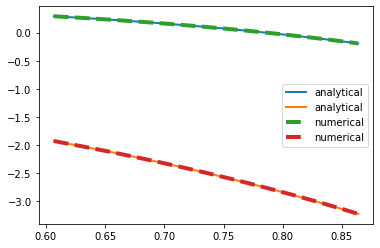

In [ ]:
# 1a
def f(t,x,u):
  x1,x2 = x
  return np.array([t*x2,2*x2 + t*u])

# keep uncommented for deterministic output
np.random.seed(547)

tf = np.random.rand()
t0 = tf - np.random.rand()
x0 = np.random.randn(2)
t_,x_ = numerical_simulation(lambda t,x : f(t,x,0),tf,x0,t0=t0,dt=1e-3)

x__ = np.asarray([(Phi_(t,t0) @ x0[:,np.newaxis]).flatten() for t in t_])

plt.figure()
plt.plot(t_,x__,lw=2,label='analytical')
plt.plot(t_,x_,'--',lw=4,label='numerical')
plt.legend();

The agreement looks really good -- the plots are visually indistinguishable.

However, note that the final state vectors differ in the third significant figure -- this is because I chose timestep `dt = 1e-3`; if you decrease the timestep the error decreases at (approximately) a linear rate (i.e. `dt = 1e-4` will give (approximately) one more significant figure of agreement).

In [ ]:
Phi_(tf,t0) @ x0[:,np.newaxis]

array([[-0.193],
       [-3.224]])

In [ ]:
x_[-1][:,np.newaxis]

array([[-0.192],
       [-3.222]])

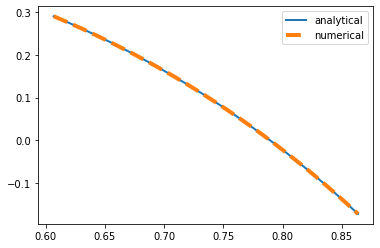

In [ ]:
# 1b
t_,x_ = numerical_simulation(lambda t,x : f(t,x,1),tf,x0,t0=t0,dt=1e-6)

y__ = np.asarray([(y_(t,t0,x0[0],x0[1])).flatten() for t in t_])

plt.figure()
plt.plot(t_,y__,lw=2,label='analytical')
plt.plot(t_,x_[:,0],'--',lw=4,label='numerical')
plt.legend();


b. Verify your answers to (2a.) and (2b.) using numerical simulations (you choose $A$).


In [ ]:
# keep uncommented for deterministic output
np.random.seed(547)

n = 2#np.random.randint(2,5)
A = np.random.randn(n,n)

def f(t,x):
  # this is a weird way to make the same function work on vector AND matrix x
  return (x.T @ A.T).T

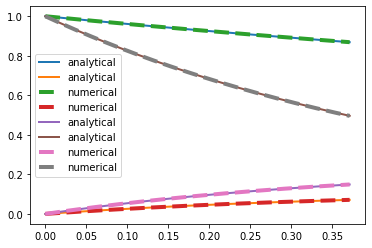

In [ ]:
# 2a
from scipy import linalg as la

tf = np.random.rand()

plt.figure()
for x0 in np.identity(n):
  t_,x_ = numerical_simulation(lambda t,x : f(t,x),tf,x0,dt=1e-3)
  x__ = np.asarray([(la.expm(A*t) @ x0[:,np.newaxis]).flatten() for t in t_])

  plt.plot(t_,x__,lw=2,label='analytical')
  plt.plot(t_,x_,'--',lw=4,label='numerical')
plt.legend();

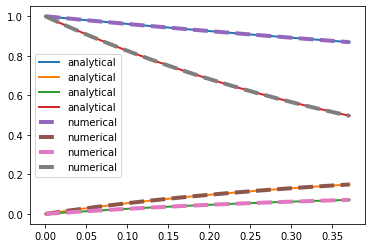

In [ ]:
# 2b
X0 = np.identity(n)

t_,X_ = numerical_simulation(lambda t,x : f(t,x),tf,X0,dt=1e-3)
X__ = np.asarray([(la.expm(A*t)) for t in t_])

plt.figure()
plt.plot(t_,X__.reshape((t_.size,n*n)),lw=2,label='analytical')
plt.plot(t_,X_.reshape((t_.size,n*n)),'--',lw=4,label='numerical')
plt.legend();


Consider the CT-LTI DE model for a single-degree-of-freedom ``MCK'' system (i.e. spring-mass-damper) defined by

$$ A = \left[\begin{array}{} 0 & 1 \\ -k/m & -c/m \end{array}\right],\ B = \left[\begin{array}{} 0 \\ 1/m \end{array}\right],\ C = \left[\begin{array}{} 1 & 0 \end{array}\right],\ D = 0, $$

where $m,c,k > 0$ are positive constants; the input $u$ is a force applied to the mass and the output $y$ is the displacement of the mass from the spring rest length.  (Note that this could equally well be interpreted as a model for a series RLC circuit with $R = c$, $L = m$, $C = 1/k$; in this case the input $u$ is a voltage source and the output $y$ is charge on the capacitor.)  You can use parameter values $m = c = k = 1$.


In [ ]:
m,c,k = 1,1,1

A = np.array([[0,1],[-k/m,-c/m]])
B = np.array([[0],[1/m]])
C = np.array([[1,0]])
D = np.array([[0]])

def f(t,x,u):
  return x.T @ A.T + u * B.flatten()


c. Numerically simulate the CT-LTI DE from initial state $x(0) = (1,1)$ and compare the simulated trajectories with those obtained by computing the matrix exponential; assume $u \equiv 0$.  


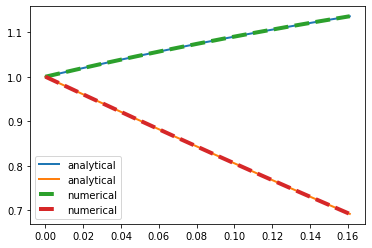

In [ ]:
# 2a
tf = np.random.rand()

x0 = np.array([1,1])

t_,x_ = numerical_simulation(lambda t,x : f(t,x,0),tf,x0,dt=1e-3)
x__ = np.asarray([(la.expm(A*t) @ x0[:,np.newaxis]).flatten() for t in t_])

plt.figure()
plt.plot(t_,x__,lw=2,label='analytical')
plt.plot(t_,x_,'--',lw=4,label='numerical')
plt.legend();


d. Numerically simulate the CT-LTI DE from initial state $x(0) = (1,1)$ with input $u(t) = \sin(t)$ and compare the result with the output obtained from the LTI DE's transfer function and describe how the two results are related.

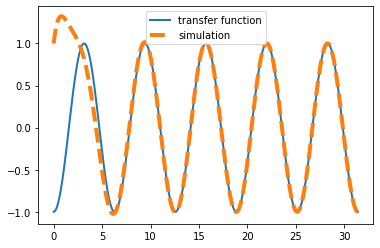

In [ ]:
# input
omega = 1
u = lambda t : np.sin(omega*t)

# simulation
tf = 5*2*np.pi/omega # 5 input cycles
x0 = np.array([1,1])
t_,x_,u_ = numerical_simulation(f,tf,x0,ut=u,dt=1e-3,return_u=True)

# simulation output
y_ = np.array([x @ C.T + [[u]] @ D.T for (x,u) in zip(x_,u_)]).flatten()

# transfer function
Tyu = lambda s : C @ la.inv(s*np.identity(2) - A) @ B + D

# output from transfer function applied to pure sinusoid
y__ = np.imag(Tyu(1.j*omega)*np.exp(1.j*omega*t_)).flatten()

plt.figure()
plt.plot(t_,y__,lw=2,label='transfer function')
plt.plot(t_[:-1],y_,'--',lw=4,label='simulation')
plt.legend();

In [4]:
1j**2

(-1+0j)